In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch peft

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from peft import LoraConfig, get_peft_model

# Load LLM

In [ ]:
# Update the model name to ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=34)  # Update `num_labels` as needed


# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [ ]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-train.csv"
val_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-val.csv"
test_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [ ]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# Update ClinicalBERT Model for Classification
model.num_labels = num_classes  # Update number of labels

# LoRA (Low-Rank Adaptation)

In [ ]:
# Lastest found: without LoRA, performance is even better
"""
# Configure LoRA for BioBERT

lora_config = LoraConfig(
    r=32,  # Low-rank adaptation rank
    lora_alpha=64,  # Scaling factor
    target_modules=["query", "value"],  # LoRA applied to attention layers
    lora_dropout=0.2,  # Dropout rate for regularization
    task_type="SEQ_CLS"  # Sequence classification task
)

model = get_peft_model(model, lora_config)
print("LoRA applied successfully to BioBERT!")
"""

'\n# Configure LoRA for BioBERT\n\nlora_config = LoraConfig(\n    r=32,  # Low-rank adaptation rank\n    lora_alpha=64,  # Scaling factor\n    target_modules=["query", "value"],  # LoRA applied to attention layers\n    lora_dropout=0.2,  # Dropout rate for regularization\n    task_type="SEQ_CLS"  # Sequence classification task\n)\n\nmodel = get_peft_model(model, lora_config)\nprint("LoRA applied successfully to BioBERT!")\n'

# Tokenize Symptoms

In [ ]:
# Tokenize Symptoms
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])

# Convert labels to tensors
train_labels = torch.tensor(train_data['encoded_labels'].tolist())
val_labels = torch.tensor(val_data['encoded_labels'].tolist())
test_labels = torch.tensor(test_data['encoded_labels'].tolist())

# Dataset Class for Fine-Tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)


# Fine-tuning BioBERT with LoRA

In [ ]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,  #7
    weight_decay= 0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.036300,0.031370
2,0.034600,0.028221
3,0.017900,0.024917
4,0.037300,0.021771
5,0.016900,0.020578
6,0.014500,0.019841


TrainOutput(global_step=17754, training_loss=0.03993065894692691, metrics={'train_runtime': 2057.8591, 'train_samples_per_second': 276.019, 'train_steps_per_second': 8.627, 'total_flos': 2.5110005092006464e+16, 'train_loss': 0.03993065894692691, 'epoch': 6.0})

# Generate ClinicalBERT Embedding for Random Forest

In [ ]:
# Generate ClinicalBERT Embeddings
def generate_embeddings(dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: batch[key].to(device) for key in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            cls_embedding = outputs.logits.cpu().numpy()  # Extract logits for embedding
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

print("Generating embeddings for training data...")
train_embeddings = generate_embeddings(train_dataset)
print("Generating embeddings for validation data...")
val_embeddings = generate_embeddings(val_dataset)
print("Generating embeddings for testing data...")
test_embeddings = generate_embeddings(SymptomDataset(test_encodings, test_labels))

Generating embeddings for training data...
Generating embeddings for validation data...
Generating embeddings for testing data...


# UMAP (Uniform Manifold Approximation and Projection)



In [ ]:
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00


Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


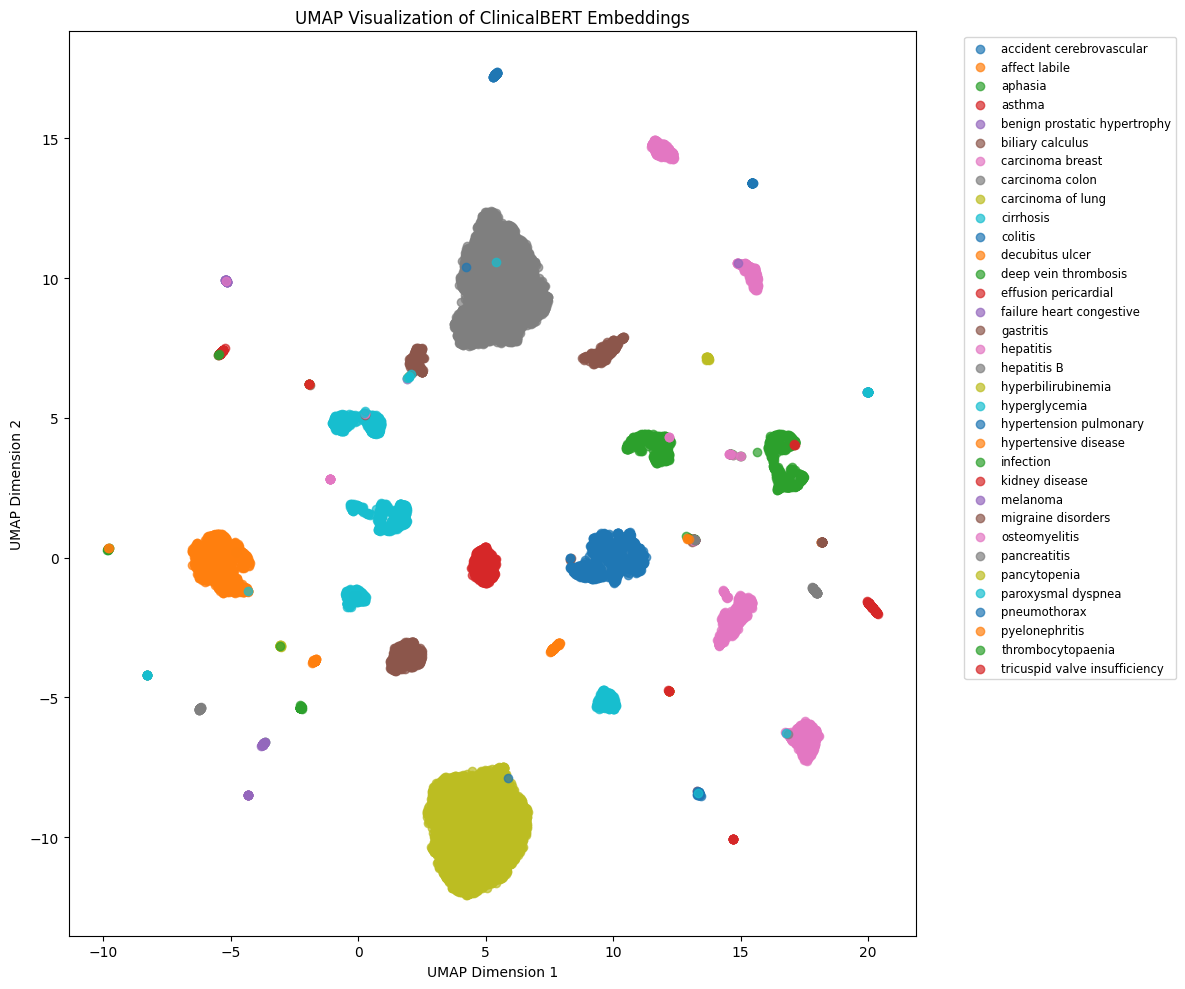

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of ClinicalBERT Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# t-SNE ( t-Distributed Stochastic Neighbor Embedding)

In [ ]:
"""
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using t-SNE)
# test_embeddings should already be generated using your generate_embeddings function.

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using t-SNE
print("Reducing dimensions using t-SNE...")
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_embeddings_tsne = tsne_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation for t-SNE
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings_tsne[indices, 0], reduced_embeddings_tsne[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("t-SNE Visualization of ClinicalBERT Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()
"""

'\nfrom sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Generate test embeddings (ensure this is executed before using t-SNE)\n# test_embeddings should already be generated using your generate_embeddings function.\n\n# Convert test labels to NumPy for easier handling\nlabels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset\n\n# Reduce dimensions using t-SNE\nprint("Reducing dimensions using t-SNE...")\ntsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)\nreduced_embeddings_tsne = tsne_model.fit_transform(test_embeddings)\n\n# Map numeric labels to disease names\ndisease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names\n\n# Plot the 2D representation for t-SNE\nplt.figure(figsize=(12, 10))\nunique_labels = np.unique(disease_names)\n\nfor disease in unique_labels:\n    indices = np.where(disease_names == disease)\n    plt.scatter(\n        reduc

# Naive Bayes

In [ ]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                       1.0       1.000000      1.0   1.000000   
recall                          1.0       0.986842      1.0   0.986842   
f1-score                        1.0       0.993377      1.0   0.993377   
support                        38.0      76.000000     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          1.000000          1.000000   
recall                         0.973684          0.946254          0.995114   
f1-score                       0.986667          0.972385          0.997551   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         1.000000           1.000000    1.000000  ...      0.387755   
recall            0.995727           0.997152    0.990

In [ ]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/Bioclinicalbert-nb-LT-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalbert-nb-LT-class.csv


# Visualize Tail-part diseases

Validation Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                       1.0       1.000000      1.0   1.000000   
recall                          1.0       0.986842      1.0   0.986842   
f1-score                        1.0       0.993377      1.0   0.993377   
support                        38.0      76.000000     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          1.000000          1.000000   
recall                         0.973684          0.946254          0.995114   
f1-score                       0.986667          0.972385          0.997551   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         1.000000           1.000000    1.000000  ...      0.387755   
recall            0.995727           0.997152    0.990

<Figure size 1800x800 with 0 Axes>

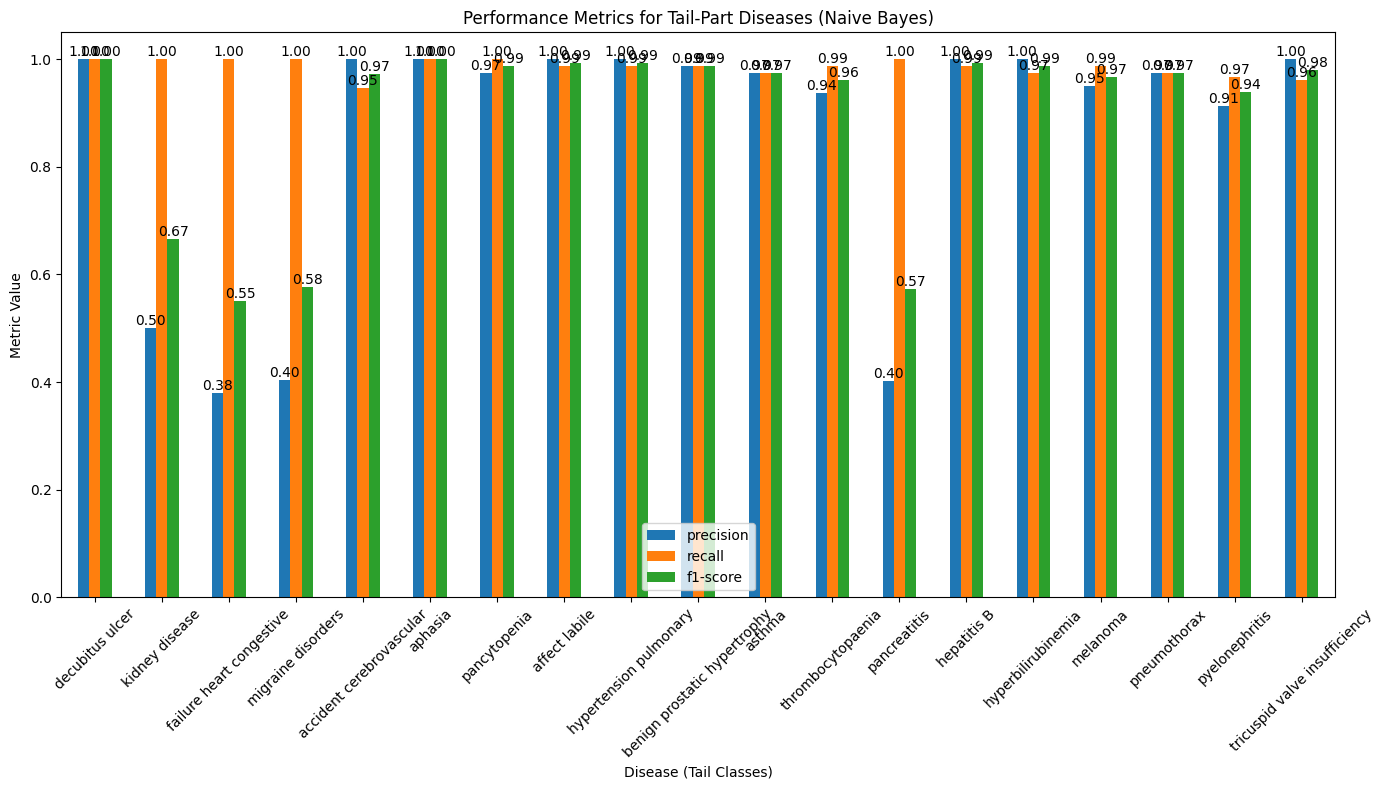

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(
    val_labels,
    val_preds,
    target_names=label_encoder.classes_,
    output_dict=True
)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(
    test_labels,
    test_preds,
    target_names=label_encoder.classes_,
    output_dict=True
)
print("Test Report:")
print(pd.DataFrame(test_report))

# Generate Classification Report for Tail-Part Diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in test_report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = test_report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (Naive Bayes)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


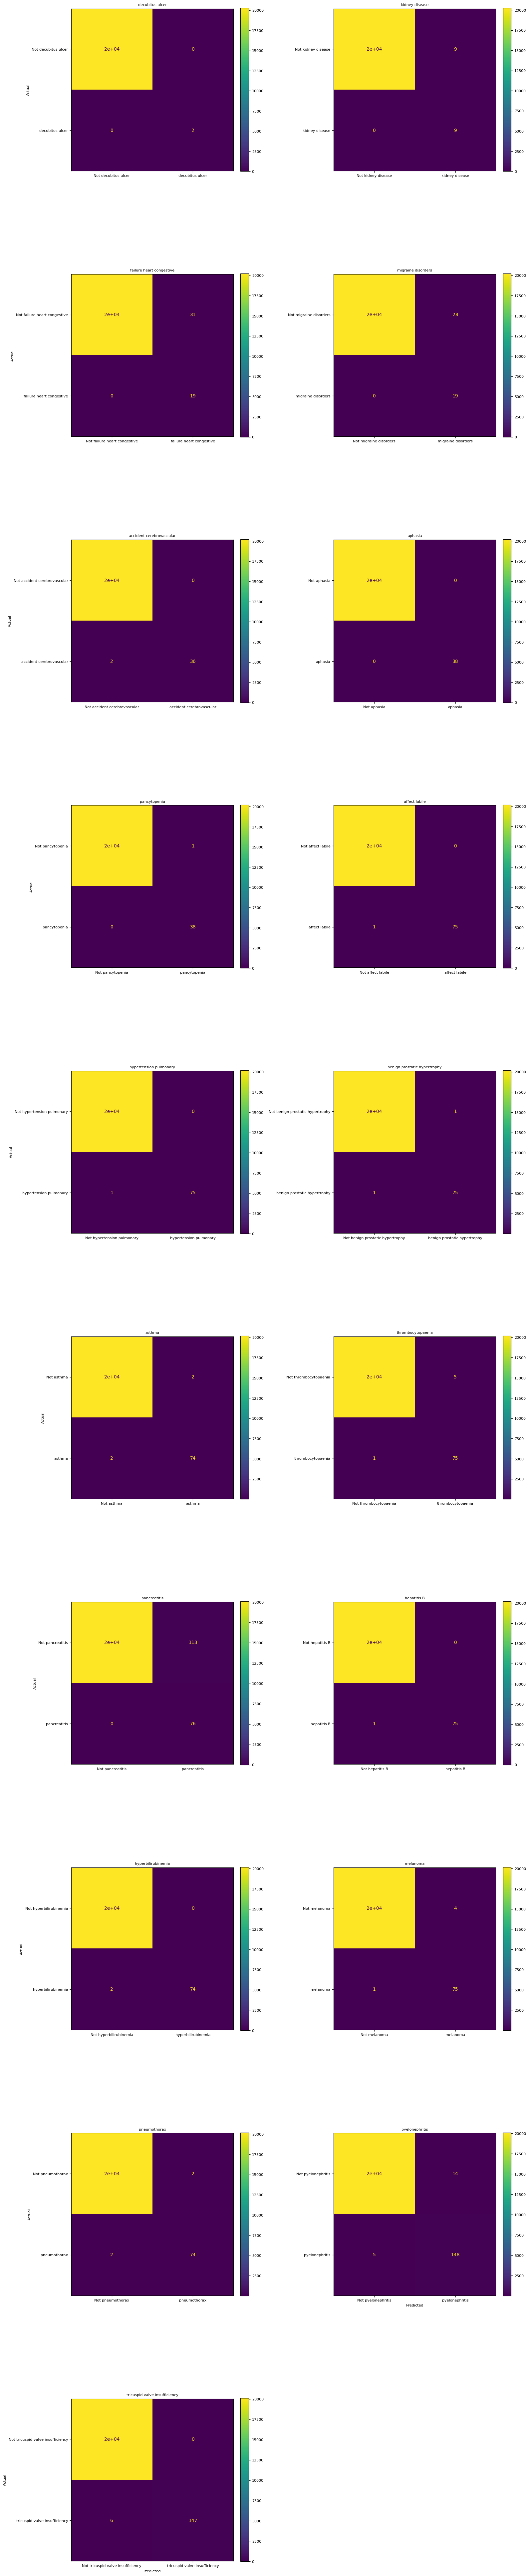

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(tail_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to NumPy array and create binary labels
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)
    y_pred_binary = (test_preds == disease_idx).astype(int)  # Assuming test_preds is already a NumPy array

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Visualize Head-Part Diseases

<Figure size 1800x800 with 0 Axes>

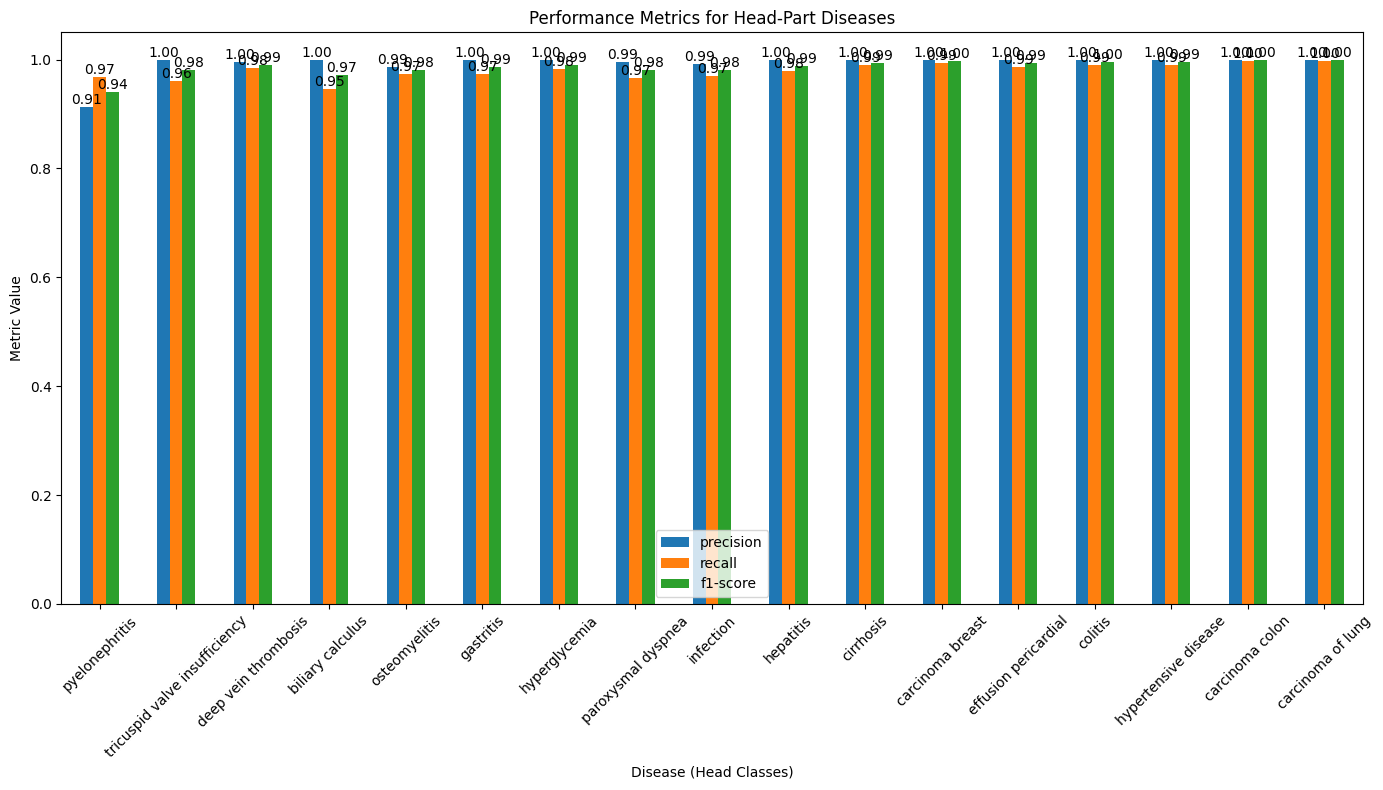

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report for test predictions
# `test_labels` and `test_preds` should come from your LLM + ML code
report_dict = classification_report(
    test_labels.cpu().numpy(),  # Convert PyTorch tensor to NumPy array
    test_preds,
    target_names=label_encoder.classes_,  # Use the disease labels
    output_dict=True,
    zero_division=0
)

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Define tail-part diseases
head_part_diseases = [
    "pyelonephritis", "tricuspid valve insufficiency", "deep vein thrombosis", "biliary calculus", "osteomyelitis",
    "gastritis", "hyperglycemia", "paroxysmal dyspnea", "infection", "hepatitis",
    "cirrhosis", "carcinoma breast", "effusion pericardial", "colitis", "hypertensive disease",
    "carcinoma colon", "carcinoma of lung"
]

# Ensure the diseases exist in the report
head_part_diseases_present = [disease for disease in head_part_diseases if disease in report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
head_metrics = report_df.loc[head_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for head-part diseases
plt.figure(figsize=(18, 8))
ax = head_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Head-Part Diseases")
plt.xlabel("Disease (Head Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                       1.0            1.0      1.0   1.000000   
recall                          1.0            1.0      1.0   0.986842   
f1-score                        1.0            1.0      1.0   0.993377   
support                        38.0           76.0     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.952769          0.995130   
recall                         0.973684          0.952769          0.998371   
f1-score                       0.986667          0.952769          0.996748   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.999389           0.999593    0.995114  ...      0.625000   
recall            0.999186           0.999390    0.995

In [ ]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/Bioclinicalbert-rf-LT-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalbert-rf-LT-class.csv


<Figure size 1800x800 with 0 Axes>

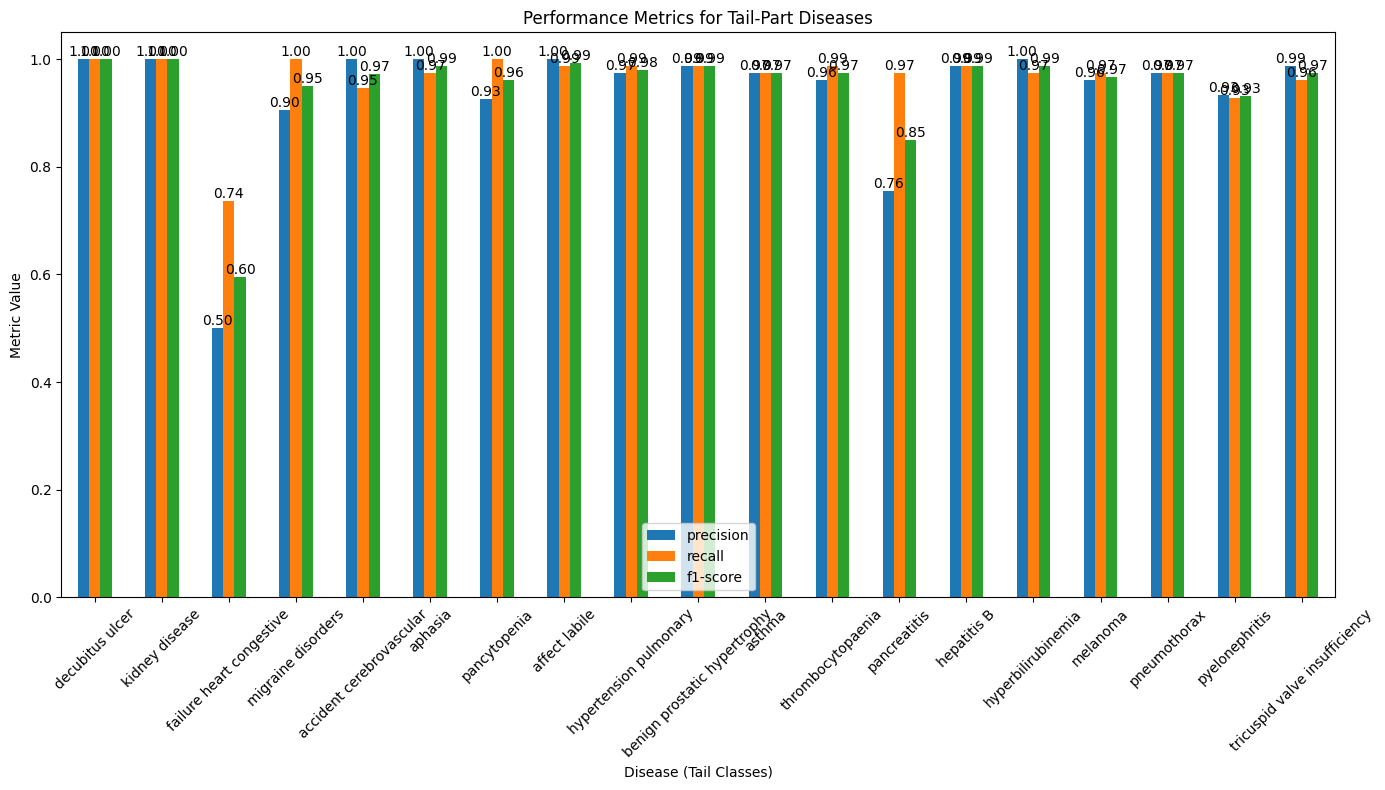

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report for test predictions
# `test_labels` and `test_preds` should come from your LLM + ML code
report_dict = classification_report(
    test_labels.cpu().numpy(),  # Convert PyTorch tensor to NumPy array
    test_preds,
    target_names=label_encoder.classes_,  # Use the disease labels
    output_dict=True,
    zero_division=0
)

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Define tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure the diseases exist in the report
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


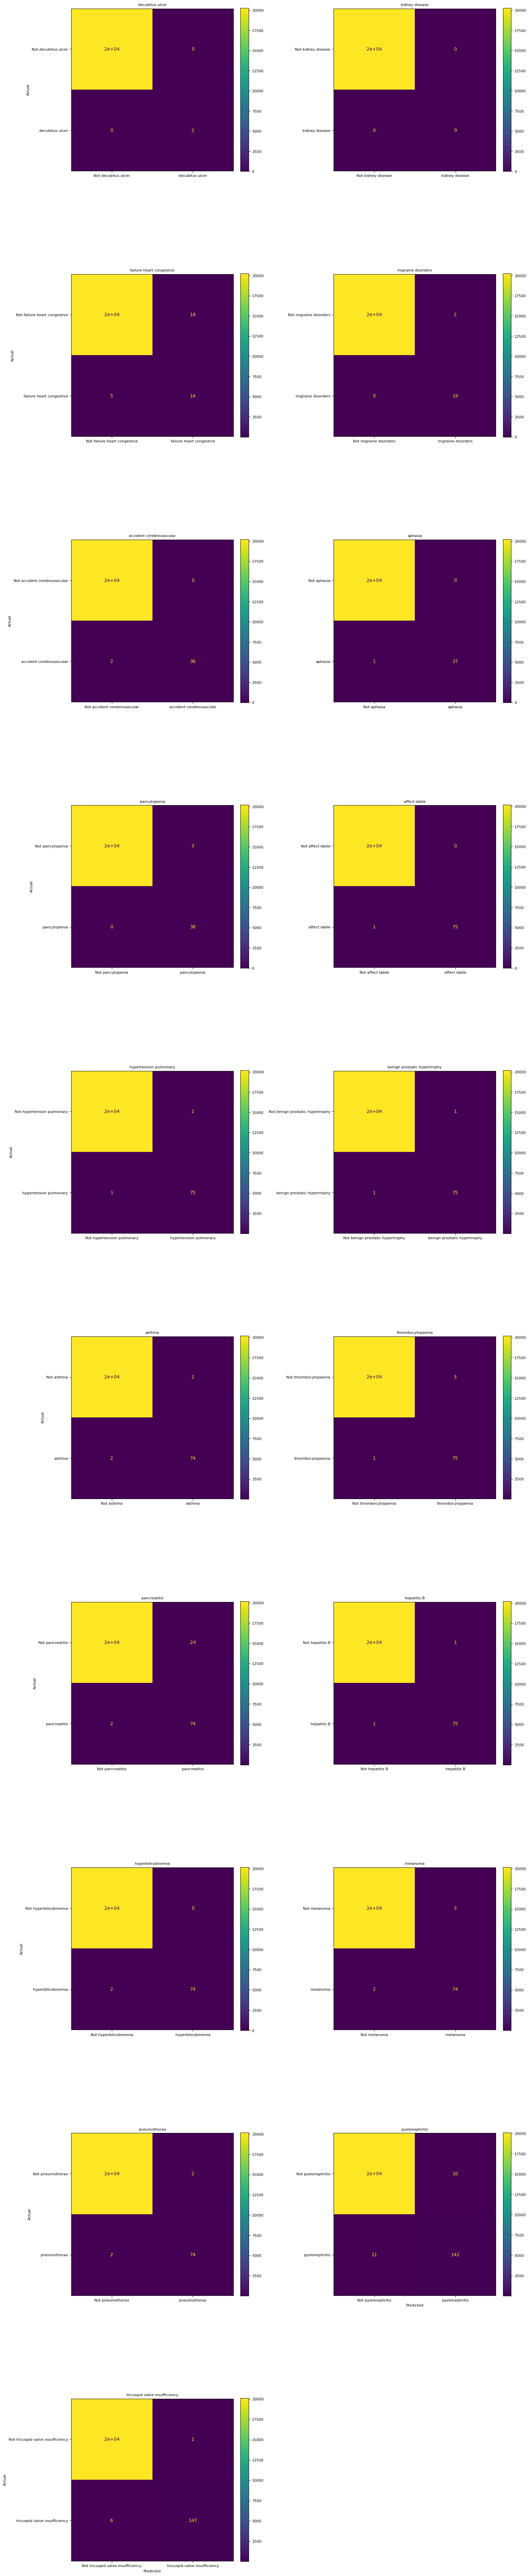

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Get the corresponding label indices for the tail-part diseases
tail_part_indices = [list(label_encoder.classes_).index(disease) for disease in tail_part_diseases]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

# Initialize plot count
plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases) + num_plots_per_row - 1) // num_plots_per_row)))

# Loop through each disease in the tail_part_diseases list
for i, (disease, disease_idx) in enumerate(zip(tail_part_diseases, tail_part_indices)):
    # Filter test data for the current disease
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)  # 1 if the disease matches, 0 otherwise
    y_pred_binary = (test_preds == disease_idx).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Visualize the head-part disease ( 17 diseases)

<Figure size 1800x800 with 0 Axes>

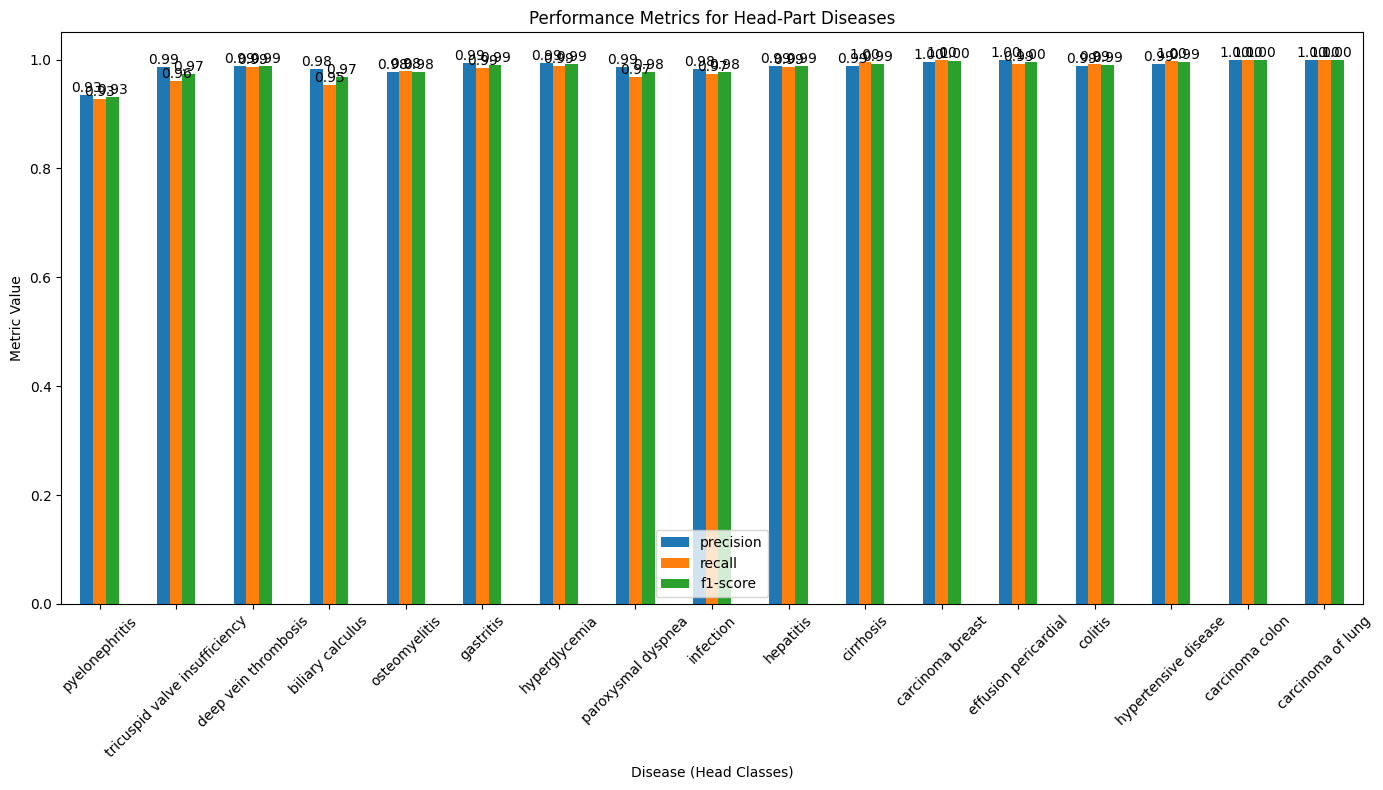

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report for test predictions
# `test_labels` and `test_preds` should come from your LLM + ML code
report_dict = classification_report(
    test_labels.cpu().numpy(),  # Convert PyTorch tensor to NumPy array
    test_preds,
    target_names=label_encoder.classes_,  # Use the disease labels
    output_dict=True,
    zero_division=0
)

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Define tail-part diseases
head_part_diseases = [
    "pyelonephritis", "tricuspid valve insufficiency", "deep vein thrombosis", "biliary calculus", "osteomyelitis",
    "gastritis", "hyperglycemia", "paroxysmal dyspnea", "infection", "hepatitis",
    "cirrhosis", "carcinoma breast", "effusion pericardial", "colitis", "hypertensive disease",
    "carcinoma colon", "carcinoma of lung"
]

# Ensure the diseases exist in the report
head_part_diseases_present = [disease for disease in head_part_diseases if disease in report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
head_metrics = report_df.loc[head_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for head-part diseases
plt.figure(figsize=(18, 8))
ax = head_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Head-Part Diseases")
plt.xlabel("Disease (Head Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Support Vector Classifier

In [ ]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf' or 'poly'
svc_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_labels, val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_labels, test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                       1.0            1.0      1.0   0.986842   
recall                          1.0            1.0      1.0   0.986842   
f1-score                        1.0            1.0      1.0   0.986842   
support                        38.0           76.0     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.991482          0.998371   
recall                         0.973684          0.947883          0.998371   
f1-score                       0.986667          0.969192          0.998371   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.998170           0.998983    0.995114  ...      0.679612   
recall            0.998983           0.999390    0.995

In [ ]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/Bioclinicalbert-svc-LT-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1.2/Dataset/LLM + ML/clinicalbert-svc-LT-class.csv


Validation Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                       1.0            1.0      1.0   0.986842   
recall                          1.0            1.0      1.0   0.986842   
f1-score                        1.0            1.0      1.0   0.986842   
support                        38.0           76.0     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.991482          0.998371   
recall                         0.973684          0.947883          0.998371   
f1-score                       0.986667          0.969192          0.998371   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.998170           0.998983    0.995114  ...      0.679612   
recall            0.998983           0.999390    0.995

<Figure size 1800x800 with 0 Axes>

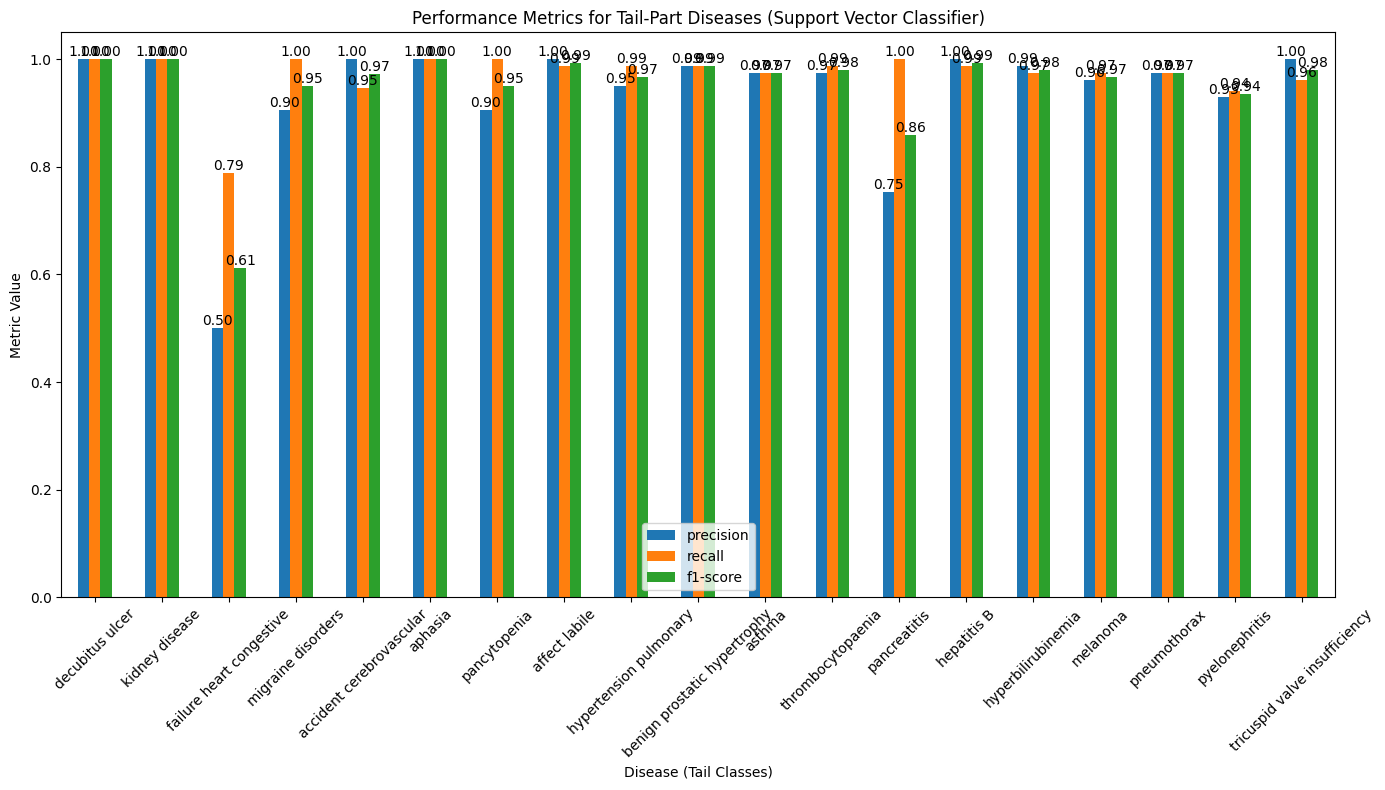

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)  # You can choose other kernels like 'rbf' or 'poly'
svc_model.fit(train_embeddings, train_data['encoded_labels'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(
    val_labels,
    val_preds,
    target_names=label_encoder.classes_,
    output_dict=True
)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(
    test_labels,
    test_preds,
    target_names=label_encoder.classes_,
    output_dict=True
)
print("Test Report:")
print(pd.DataFrame(test_report))

# Generate Classification Report for Tail-Part Diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in test_report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
tail_metrics = test_report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for tail-part diseases
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (Support Vector Classifier)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


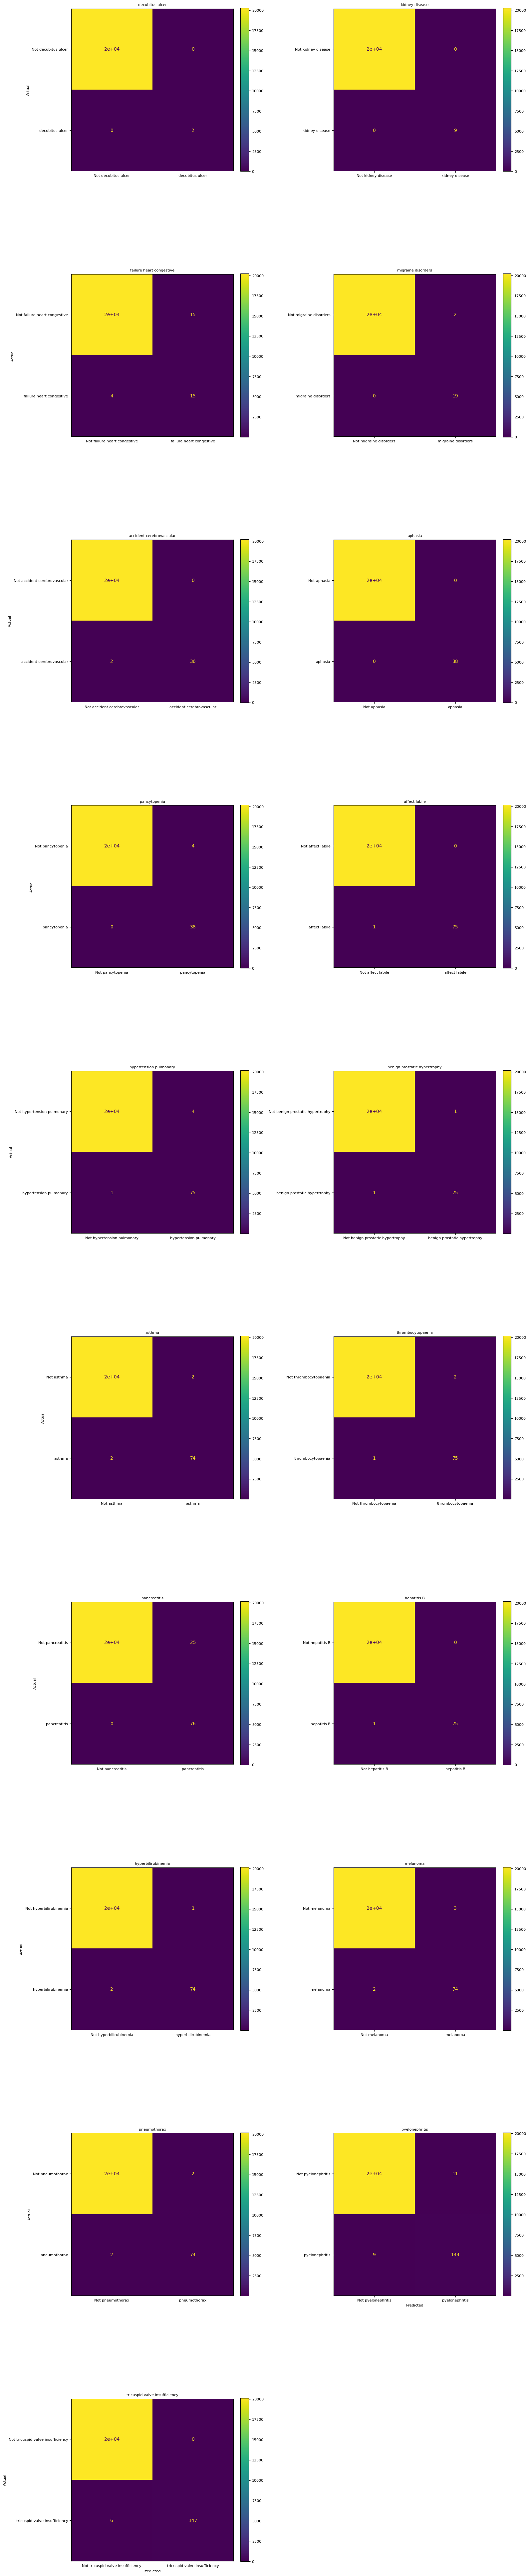

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(tail_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to NumPy array and create binary labels
    y_test_binary = (test_labels.cpu().numpy() == disease_idx).astype(int)
    y_pred_binary = (test_preds == disease_idx).astype(int)  # Assuming test_preds is already a NumPy array

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Visualize Head-part diseases

<Figure size 1800x800 with 0 Axes>

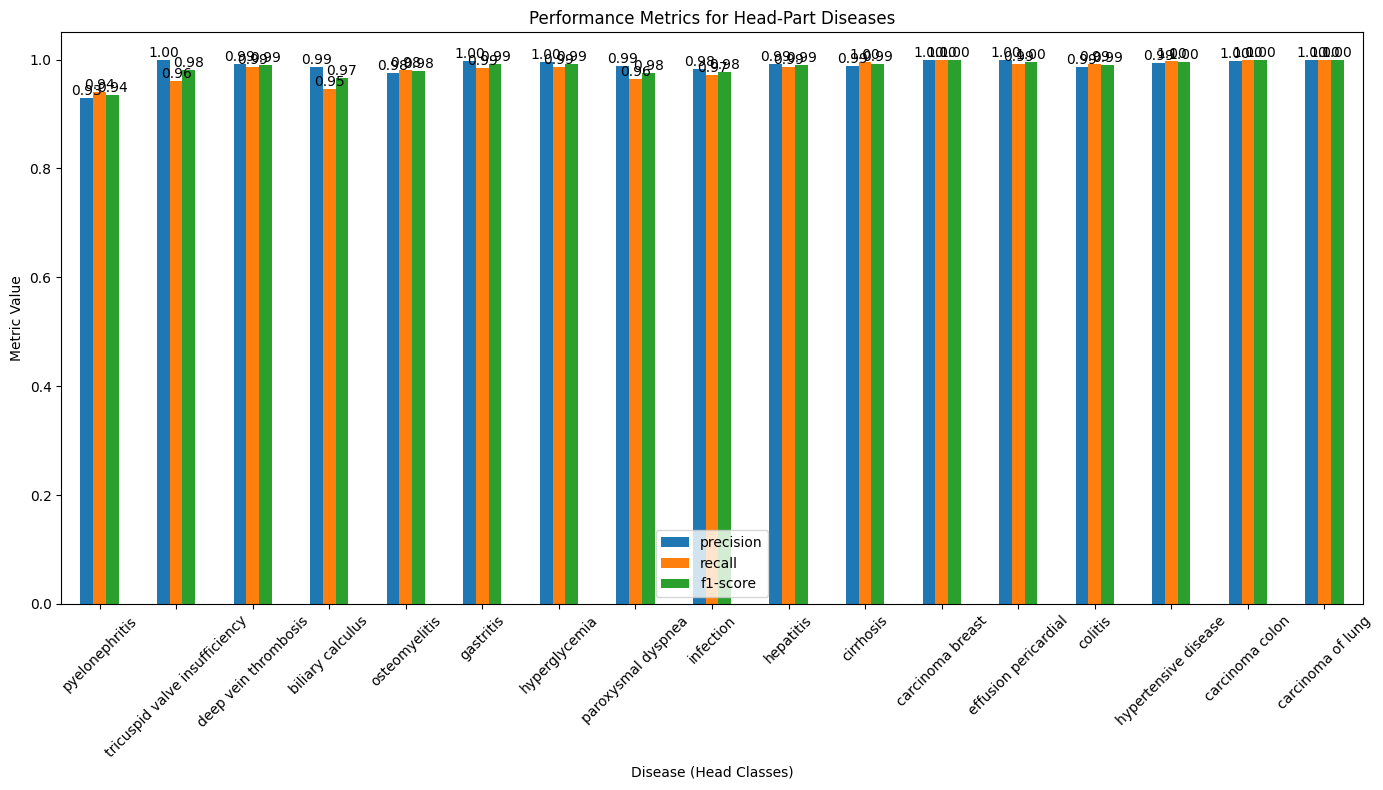

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate the classification report for test predictions
# `test_labels` and `test_preds` should come from your LLM + ML code
report_dict = classification_report(
    test_labels.cpu().numpy(),  # Convert PyTorch tensor to NumPy array
    test_preds,
    target_names=label_encoder.classes_,  # Use the disease labels
    output_dict=True,
    zero_division=0
)

# Convert the report dictionary into a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Define tail-part diseases
head_part_diseases = [
    "pyelonephritis", "tricuspid valve insufficiency", "deep vein thrombosis", "biliary calculus", "osteomyelitis",
    "gastritis", "hyperglycemia", "paroxysmal dyspnea", "infection", "hepatitis",
    "cirrhosis", "carcinoma breast", "effusion pericardial", "colitis", "hypertensive disease",
    "carcinoma colon", "carcinoma of lung"
]

# Ensure the diseases exist in the report
head_part_diseases_present = [disease for disease in head_part_diseases if disease in report_df.index]

# Extract metrics for the diseases in the tail_part_diseases list
head_metrics = report_df.loc[head_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics for head-part diseases
plt.figure(figsize=(18, 8))
ax = head_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Head-Part Diseases")
plt.xlabel("Disease (Head Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
